In [1]:
# import libs
import os
import warnings
import numpy as np
import pandas as pd
import networkx as nx
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
# read GTFS dataset
fname_gtfs = 'gtfs_formated_fev_2024'
gtfs = pd.read_parquet(f'/mnt/data/sobe_desce/static_tables/gtfs_bus/{fname_gtfs}.parquet')
gtfs = gtfs.astype({'stop_id': str})
# drop shape_id with bug
shapes_to_drop = ['57354_V', '61388_I', '61975_V', '61068_V', '61388_I', '69651_I', '69572_V', '68562_V']
gtfs = gtfs.query(" shape not in @shapes_to_drop")
gtfs.head()

,linha_atend,linha,cod_ate,sentido,shape,ordem,stop_id,lat,lon,distancias,acumulado,posicao
0,1321_12432,1321,12432,I,12432_I,1,45833944,-12.929167,-38.437500,0.000,0.000,inicial
1,1321_12432,1321,12432,I,12432_I,2,44784089,-12.926615,-38.436531,0.309,0.309,intermediario
2,1321_12432,1321,12432,I,12432_I,3,45833505,-12.925073,-38.439533,0.353,0.662,intermediario
3,1321_12432,1321,12432,I,12432_I,4,44165028,-12.923343,-38.440968,0.288,0.950,intermediario
4,1321_12432,1321,12432,I,12432_I,5,44783562,-12.920358,-38.442822,0.387,1.337,intermediario


In [4]:
def create_edges(df_graph: pd.DataFrame, cols_group):
    nodes = []
    for _, df_line in tqdm(df_graph.groupby(cols_group)):# ['linha_atend', 'sentido']
        # sort values from line, sentido, ordem
        df_line = df_line.sort_values(['sentido', 'ordem'])
        df_line['stop_id_to'] = df_line['stop_id'].shift(-1)
        df_line['distance_to'] = df_line['distancias'].shift(-1)
        # drop
        df_line = df_line[df_line.stop_id_to.notna()]
        cols = ['stop_id', 'stop_id_to', 'distance_to', 'linha', 'cod_ate', 'sentido', 'shape']
        nodes.append(df_line[cols])
    # create a graph dataframe
    df_nodes = pd.concat(nodes)
    df_nodes = df_nodes.rename({'stop_id': 'src', 
                                'stop_id_to': 'dst', 
                                'distance_to': 'distance'}, axis=1)
    
    # remove  duplicates
    df_nodes_pairs = df_nodes.pivot_table(index=['src', 'dst'], 
                                                 values=['distance'], 
                                                 aggfunc=np.min).reset_index()
    
    # df_nodes_pairs = df_nodes.pivot_table(index=['src', 'dst'], 
    #                                              values=['linha', 'cod_ate', 'sentido', 'shape'], 
    #                                              aggfunc=pd.Series.nunique).reset_index()
        
        
    #df_nodes_unique = df_nodes.drop_duplicates()    
    #df_nodes_unique  = df_nodes_unique[~df_nodes_unique[['src', 'dst']].duplicated()]
    
    return df_nodes_pairs, df_nodes

In [5]:
def add_coordinates(df_graph, df_gtfs):
    
    # get coordinates from each stop_id
    cols = ['stop_id', 'lat', 'lon']
    df_nodes = df_gtfs.pivot_table(index=cols, aggfunc=set).reset_index()[cols]
    df_nodes = df_nodes[~df_nodes.stop_id.duplicated()]
    
    # Criar o dicionário
    stop_coordinates = {}
    for i in df_nodes.index:
        lat = df_nodes.loc[i, "lat"]
        lon = df_nodes.loc[i, "lon"]
        node = df_nodes.loc[i, "stop_id"]
        stop_coordinates[node] = [lat, lon]
        
    #
    df_graph['src_lat'] = None
    df_graph['dst_lat'] = None
    df_graph['src_lon'] = None
    df_graph['dst_lon'] = None

    for idx in tqdm(range(df_graph.shape[0])):

        lat, lon   = stop_coordinates[df_graph.src.iloc[idx]]
        latd, lond = stop_coordinates[df_graph.dst.iloc[idx]] 

        df_graph['src_lat'].iloc[idx] = lat
        df_graph['dst_lat'].iloc[idx] = latd
        df_graph['src_lon'].iloc[idx] = lon
        df_graph['dst_lon'].iloc[idx] = lond
    
    return df_graph

In [6]:
def create_graph_networkx(df_graph):
    G = nx.DiGraph()
    
    # Add nodes with latitude and longitude attributes
    for index, row in df_graph.iterrows():
        G.add_node(row['src'], lat=row['src_lat'], lon=row['src_lon'])
        G.add_node(row['dst'], lat=row['dst_lat'], lon=row['dst_lon'])

    # Add edges with distance attribute
    for index, row in df_graph.iterrows():
        G.add_edge(row['src'], row['dst'], distance=row['distance'])
    
    pos = {node[0]: (node[1]['lon'], node[1]['lat']) for node in G.nodes(data=True)}
    
    return G, pos

## Main

In [7]:
# create edges
df_graph_edges, df_graph_edges_all  = create_edges(gtfs, ['shape'])
print(f"instaces: {df_graph_edges.shape}")# 4543
df_graph_edges.head()

100% 777/777 [00:01<00:00, 444.08it/s]


instaces: (4526, 3)


,src,dst,distance
0,100009577,345936831,0.254
1,100722777,100722778,0.362
2,100722777,44782645,1.062
3,100722777,45833440,0.417
4,100722777,66771046,0.934


In [8]:
df_graph_edges.describe()

,distance
count,4526.000000
mean,0.469940
std,0.521761
min,0.000000
25%,0.198000
50%,0.337000
75%,0.567000
max,7.076000


In [9]:
# add coordinates from fg_graph
df_graph_edges_coord = add_coordinates(df_graph_edges, gtfs)
print(f"Instances: {df_graph_edges_coord.shape}")
df_graph_edges_coord.head()

100% 4526/4526 [00:04<00:00, 1114.69it/s]

Instances: (4526, 7)


,src,dst,distance,src_lat,dst_lat,src_lon,dst_lon
0,100009577,345936831,0.254,-12.901954,-12.902051,-38.419582,-38.417114
1,100722777,100722778,0.362,-12.899299,-12.896647,-38.407673,-38.408215
2,100722777,44782645,1.062,-12.899299,-12.899458,-38.407673,-38.412964
3,100722777,45833440,0.417,-12.899299,-12.896741,-38.407673,-38.408672
4,100722777,66771046,0.934,-12.899299,-12.89679,-38.407673,-38.41254


In [10]:
# create graph networkx
gnx, pos = create_graph_networkx(df_graph_edges_coord)
num_nodes = gnx.number_of_nodes()
num_edges = gnx.number_of_edges()
print(f"Numero de nós  .......: {num_nodes}")
print(f"Numero de arestas ....: {num_edges}")

Numero de nós  .......: 2871
Numero de arestas ....: 4526


## Save

In [22]:
df_graph_edges_coord.to_parquet('data/graph_designer/graph_gtfs_fev_2024.parquet', index=False) 
nx.write_gpickle(gnx, 'data/graph_designer/graph_gtfs_fev_2024.gpickle')

## Plot

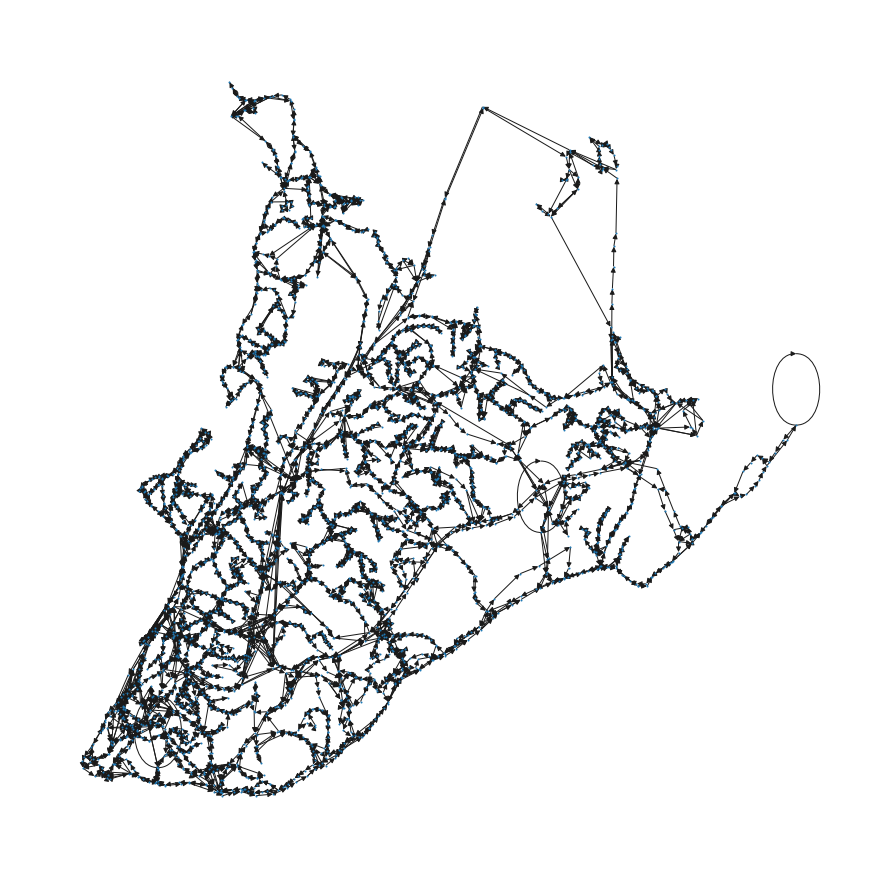

In [12]:
plt.figure(figsize=(12,12))
nx.draw(gnx, pos=pos, with_labels=False, node_size=1)
plt.show()

## Distances outliears

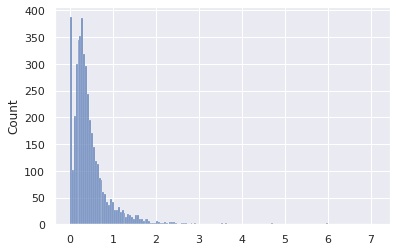

In [13]:
sns.histplot(df_graph_edges_coord.distance.values)
plt.show()

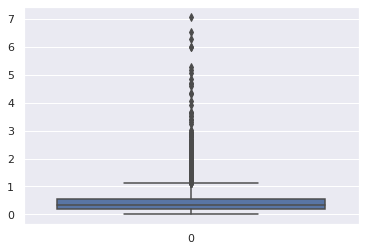

In [14]:
sns.boxplot(df_graph_edges_coord.distance.values)
plt.show()

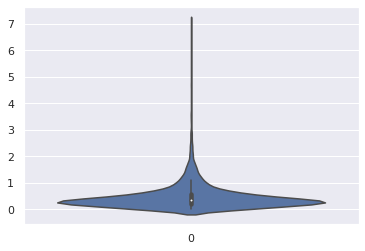

In [15]:
sns.violinplot(df_graph_edges_coord.distance.values)
plt.show()

In [16]:
df_graph_edges_coord.distance.describe()

count    4526.000000
mean        0.469940
std         0.521761
min         0.000000
25%         0.198000
50%         0.337000
75%         0.567000
max         7.076000
Name: distance, dtype: float64

In [17]:
df_graph_edges_coord[df_graph_edges_coord.distance > 7]

,src,dst,distance,src_lat,dst_lat,src_lon,dst_lon
4405,69373013,63768247,7.076,-12.851871,-12.882827,-38.383434,-38.364365


In [18]:
shapes_to_drop = ['57354_V', '61388_I', '61975_V', '61068_V', '61388_I', '69651_I', '69572_V', '68562_V']

src, dst = '69373013', '63768247'

In [19]:
df_graph_edges.query(f" src == '{src}' and dst == '{dst}' ")

,src,dst,distance,src_lat,dst_lat,src_lon,dst_lon
4405,69373013,63768247,7.076,-12.851871,-12.882827,-38.383434,-38.364365


In [20]:
shape_id = df_graph_edges_all.query(f" src == '{src}' and dst == '{dst}' ")['shape'].unique()
df_graph_edges_all.query(f" src == '{src}' and dst == '{dst}' ")

,src,dst,distance,linha,cod_ate,sentido,shape
10444,69373013,63768247,7.076,1025,54007,V,54007_V
11803,69373013,63768247,7.078,102501,55943,I,55943_I


In [21]:
gtfs.query(" shape in @shape_id ")

,linha_atend,linha,cod_ate,sentido,shape,ordem,stop_id,lat,lon,distancias,acumulado,posicao
10431,1025_54007,1025,54007,V,54007_V,1,59122394,-12.831676,-38.367191,0.000,0.000,inicial
10432,1025_54007,1025,54007,V,54007_V,2,59122393,-12.831503,-38.365566,0.182,0.182,intermediario
10433,1025_54007,1025,54007,V,54007_V,3,262863727,-12.832234,-38.364956,0.094,0.276,intermediario
10434,1025_54007,1025,54007,V,54007_V,4,262863728,-12.833305,-38.364273,0.191,0.467,intermediario
10435,1025_54007,1025,54007,V,54007_V,5,262863730,-12.834682,-38.363323,0.154,0.621,intermediario
10436,1025_54007,1025,54007,V,54007_V,6,262863729,-12.837694,-38.362514,0.373,0.994,intermediario
10437,1025_54007,1025,54007,V,54007_V,7,262863731,-12.838655,-38.362709,0.119,1.113,intermediario
10438,1025_54007,1025,54007,V,54007_V,8,59122402,-12.833168,-38.377518,1.839,2.952,intermediario
10439,1025_54007,1025,54007,V,54007_V,9,82414048,-12.835116,-38.378571,4.680,7.632,intermediario
10440,1025_54007,1025,54007,V,54007_V,10,82414047,-12.838645,-38.377678,0.446,8.078,intermediario
